# Лабораторная работа 6: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

#### Решения 

In [ ]:
#!pip3 install cvxopt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


Проверка размеров:
P: (2, 2), G: (4, 2), h: (4, 1), q: (2, 1)

[QP] status: optimal
[QP] x* = [2.9999998301061535, 1.9986909284531618]
[QP] f* = -30.99999280553902
[QP] f_original(x*) = -31.00
[QP] Active constraints: ['x1 + x2 = 5', 'x1 = 3']


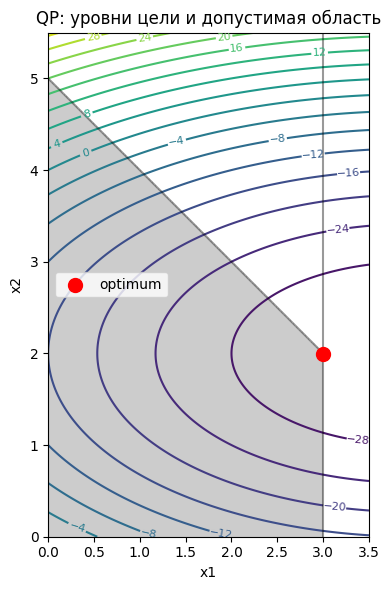

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

solvers.options['show_progress'] = False # [скрываем лог итераций]

# [P и q задают 1/2 x^T P x + q^T x]
P = matrix([[2.0, 0.0],
            [0.0, 8.0]], tc='d') # typecode = double
q = matrix([-8.0, -16.0], tc='d')

# [G (4x2) usando NumPy para claridad]
G_np = np.array([
    [-1.0,  0.0],   # -x1 <= 0
    [ 0.0, -1.0],   # -x2 <= 0
    [ 1.0,  1.0],   # x1 + x2 <= 5
    [ 1.0,  0.0]    # x1 <= 3
])
G = matrix(G_np)
h = matrix([0.0, 0.0, 5.0, 3.0], tc='d')

print("Проверка размеров:")
print(f"P: {P.size}, G: {G.size}, h: {h.size}, q: {q.size}")

# [Решаем QP]
sol = solvers.qp(P, q, G, h)
x_opt = np.array(sol['x']).flatten() #one dimension list

print("\n[QP] status:", sol['status'])
print("[QP] x* =", x_opt.tolist())
print("[QP] f* =", sol['primal objective'])

x1s, x2s = x_opt
f_original = x1s**2 + 4*x2s**2 - 8*x1s - 16*x2s
print(f"[QP] f_original(x*) = {f_original:.2f}")

# [Проверяем активные ограничения]
eps = 2e-3
active = []
if abs(x1s) < eps: active.append("x1 = 0")
if abs(x2s) < eps: active.append("x2 = 0")
if abs(x1s + x2s - 5.0) < eps: active.append("x1 + x2 = 5")
if abs(x1s - 3.0) < eps: active.append("x1 = 3")
print("[QP] Active constraints:", active)

# [Визуализация уровней и допустимой области]
x1 = np.linspace(0, 3.5, 300)
x2 = np.linspace(0, 5.5, 300)
XX, YY = np.meshgrid(x1, x2)
F = XX**2 + 4*YY**2 - 8*XX - 16*YY
mask = (XX >= 0) & (YY >= 0) & (XX + YY <= 5) & (XX <= 3) # Допустимая область: x1>=0, x2>=0, x1+x2<=5, x1<=3

plt.figure(figsize=(6, 6))
cs = plt.contour(XX, YY, F, levels=20, cmap='viridis')
plt.clabel(cs, inline=1, fontsize=8)
plt.imshow(mask, origin='lower', extent=[0, 3.5, 0, 5.5],
           alpha=0.2, cmap='Greys') # Полупрозрачная закраска допустимой области
plt.scatter([x1s], [x2s], c='red', s=100, label='optimum', zorder=5) # Оптимум
plt.plot([0, 3], [5, 2], 'k-', alpha=0.4, lw=1.5) # [линия x1+x2=5]
plt.axvline(3, color='k', alpha=0.4, lw=1.5) # [линия x1=3]
plt.xlim(0, 3.5); plt.ylim(0, 5.5)
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('QP: уровни цели и допустимая область')
plt.legend(); plt.tight_layout(); plt.show()


#### Выводы (Задание 1)

Установлен и протестирован QP-солвер CVXOPT. Решена тестовая задача минимизации квадратичной функции с линейными ограничениями.

**Результат:** Найдена оптимальная точка $x^* = (3.0, 2.0)$ со значением $f(x^*) = -31.0$.  
        В оптимуме активны ограничения $x_1 = 3$ и $x_1 + x_2 = 5$.

**Геометрия:** Оптимум расположен в угловой точке допустимой области — на пересечении двух активных ограничений. Визуализация подтверждает корректность решения.

**Замечание:** При работе с CVXOPT важно соблюдать размерности матриц и использовать тип `'d'`. Для матрицы ограничений $G$ размер должен быть $(m \times n)$ — число ограничений на число переменных.


## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [ ]:
# ============================================
# Ejercicio 2 — Линейный SVM (DUAL ФОРМУЛИРОВКА)
# Комментарии — на русском.
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.datasets import make_classification, make_circles, make_moons

solvers.options['show_progress'] = False

# ============================================
# 1. РЕАЛИЗАЦИЯ ЛИНЕЙНОГО SVM ЧЕРЕЗ DUAL QP
# ============================================

def train_linear_svm_dual(X, y, C=1.0):
    """
    Обучение линейного SVM через двойственную (dual) постановку QP.
    
    Dual: max sum(alpha_i) - 1/2 sum_ij alpha_i alpha_j y_i y_j (x_i^T x_j)
    при 0 <= alpha_i <= C и sum(alpha_i y_i) = 0
    
    Параметры:
    - X: матрица признаков (N, d)
    - y: метки классов {-1, +1}, массив (N,)
    - C: гиперпараметр регуляризации
    
    Возвращает:
    - w: вектор весов
    - b: сдвиг
    - support_vectors: маска опорных векторов
    - alpha: множители Лагранжа
    """
    N, d = X.shape
    
    # [Матрица ядра K = X X^T]
    K = X @ X.T
    
    # [P = (y_i y_j) ⊙ K — поэлементное произведение]
    P = matrix((np.outer(y, y) * K).astype(float)) # np.outer(y,y) produce una matriz 
    
    # [q = -1 (минус единичный вектор)]
    q = matrix(-np.ones(N)) # para minimizar
    
    # [Ограничения: 0 <= alpha_i <= C]
    # [В виде Gz <= h: -alpha <= 0 и alpha <= C]
    G = matrix(np.vstack([-np.eye(N), np.eye(N)])) # 2 matrices unidas, donde la 1ra mitad tiene diagonal -1 y la 2da mitad 1
    h = matrix(np.hstack([np.zeros(N), C * np.ones(N)]))
    
    # [Ограничение равенства: sum(alpha_i y_i) = 0]    Aα=b
    A = matrix(y.astype(float).reshape(1, -1)) # .reshape(1, -1) convierte y en una matriz de tamaño (1, N): una sola fila con todas las etiquetas.
    b_eq = matrix(0.0)
    
    # [Решаем QP]
    sol = solvers.qp(P, q, G, h, A, b_eq)
    
    # [Извлекаем множители Лагранжа]
    alpha = np.array(sol['x']).flatten()
    
    # [Опорные векторы: alpha_i > порог]
    support_vectors = alpha > 1e-5
    
    # [Вычисляем w = sum(alpha_i y_i x_i)]
    w = (alpha * y) @ X
    
    # [Вычисляем b по опорным векторам с 0 < alpha < C]
    margin_sv = (alpha > 1e-5) & (alpha < C - 1e-5) #buleano
    if np.any(margin_sv):
        b = np.mean(y[margin_sv] - (X[margin_sv] @ w))
    else:
        # [Если нет векторов на границе, используем все SV]
        b = np.mean(y[support_vectors] - (X[support_vectors] @ w))
    
    return w, b, support_vectors, alpha


# ============================================
# 2. ГЕНЕРАЦИЯ ТРЕХ ТИПОВ ВЫБОРОК
# ============================================

np.random.seed(42)

# [Выборка 1: линейно-разделимые классы]
X_linear, y_linear = make_classification(
    n_samples=100, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=2.5, random_state=42      # class_sep=2.5 separación grande entre clases 
)
y_linear = 2 * y_linear - 1 # y_linear por defecto es {0,1}, por eso lo pasamos a {-1,1}

# [Выборка 2: хорошо разделимые, но не линейно (концентрические круги)]
X_circles, y_circles = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=42) #factor=0.5,relación de radios entre círculo interno y externo
y_circles = 2 * y_circles - 1

# [Выборка 3: плохо разделимые классы]
X_hard, y_hard = make_classification(
    n_samples=100, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=0.5, flip_y=0.15, random_state=42  # class_sep=0.5 las nubes de puntos se solapan más
)
y_hard = 2 * y_hard - 1


# ============================================
# 3. ВИЗУАЛИЗАЦИЯ SVM
# ============================================

def plot_svm(X, y, w, b, alpha, C, title="Linear SVM"):
    """
    Визуализирует разделяющую прямую, коридор ±1 и опорные векторы.
    Различает SV на границе (0<α<C) и SV с ошибками (α=C).
    """
    plt.figure(figsize=(7, 7))
    
    # [Рисуем точки]
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='o',  label='Класс +1', edgecolor='k', s=50, alpha=0.7) #X[y==1, 0] toma la coordenada x1 de los puntos de clase +1.
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='red', marker='s', label='Класс -1', edgecolor='k', size=50, alpha=0.7)
    
    # [SV на границе коридора: 0 < alpha < C]
    margin_sv = (alpha > 1e-5) & (alpha < C - 1e-5)
    if np.any(margin_sv):
        plt.scatter(X[margin_sv, 0], X[margin_sv, 1], 
                    s=200, facecolors='none', edgecolors='green', 
                    linewidths=2.5, label='SV на границе (0<α<C)')
    
    # [SV с ошибками: alpha = C]
    error_sv = alpha >= C - 1e-5
    if np.any(error_sv):
        plt.scatter(X[error_sv, 0], X[error_sv, 1], 
                    s=150, facecolors='none', edgecolors='orange', 
                    linewidths=1.5, label=f'SV с ошибками (α≈C)', alpha=0.6)
    
    # [Разделяющая прямая и коридор]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1     # min(x_1) -1,  max(x_1) + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1     # min(x_2) -1,  max(x_2) + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    Z = xx * w[0] + yy * w[1] + b       # f(x) = w1x1 + w2x2 + b
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], # f(x) = -1, 0 ,1
                linestyles=['--', '-', '--'], 
                colors=['gray', 'green', 'gray'], 
                linewidths=[2, 2.5, 2])
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('$x_1$', fontsize=12)
    plt.ylabel('$x_2$', fontsize=12)
    plt.title(title, fontsize=13)
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # [translate:Статистика]
    print(f"  SV на границе (0<α<C): {margin_sv.sum()}")
    print(f"  SV с ошибками (α=C): {error_sv.sum()}")



ВЫБОРКА 1: Линейно-разделимые классы
Число опорных векторов: 2
Максимальный alpha: 0.1547


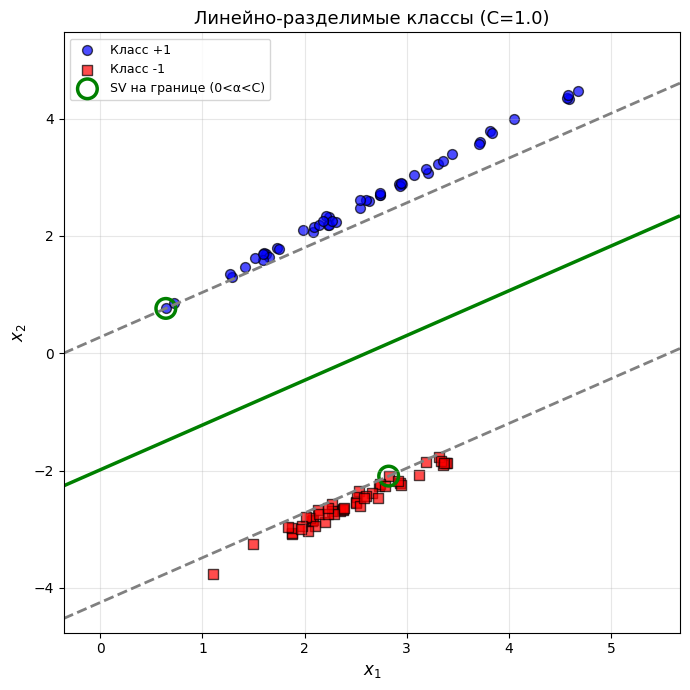

  SV на границе (0<α<C): 2
  SV с ошибками (α=C): 0


In [5]:
# ============================================
# 4. ТЕСТИРОВАНИЕ НА ТРЕХ ВЫБОРКАХ
# ============================================

print("="*60)
print("ВЫБОРКА 1: Линейно-разделимые классы")
print("="*60)

w1, b1, sv1, alpha1 = train_linear_svm_dual(X_linear, y_linear, C=1.0)
print(f"Число опорных векторов: {sv1.sum()}")
print(f"Максимальный alpha: {alpha1.max():.4f}")
plot_svm(X_linear, y_linear, w1, b1, alpha1, C=1.0, 
         title="Линейно-разделимые классы (C=1.0)")

**Результаты:** Линейно-разделимые классы (C=1.0)

На графике показана идеальная линейная разделимость: два класса (синие круги и красные квадраты) чётко разделены зелёной прямой с широким коридором (серые пунктирные линии).

**Опорные векторы:** Только 2 точки (отмечены зелёными кольцами) находятся на границах коридора и определяют положение разделяющей гиперплоскости. Остальные точки не влияют на решение.

**Интерпретация:** При линейной разделимости SVM находит оптимальный марджин с минимальным числом опорных векторов. Все множители Лагранжа $\alpha_i < C$, что означает отсутствие нарушений марджина.



ВЫБОРКА 2: Не линейно-разделимые (круги)
Число опорных векторов: 100
Максимальный alpha: 1.0000


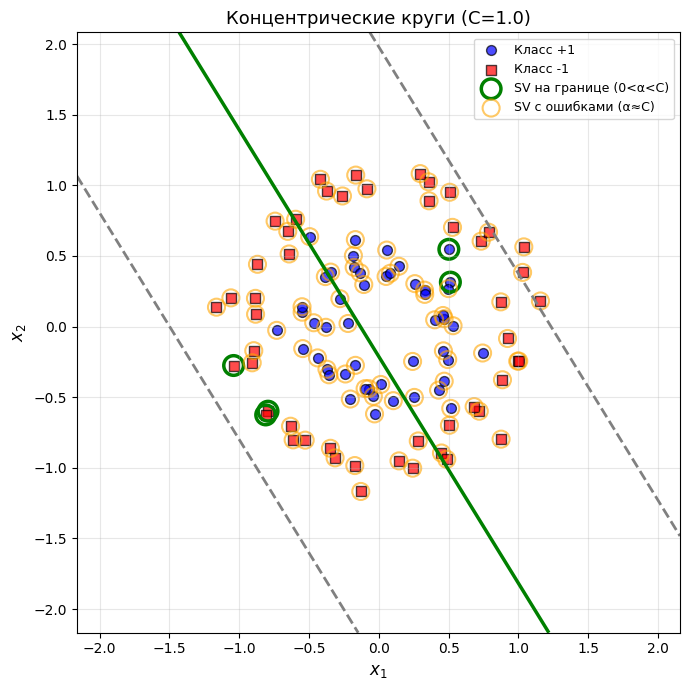

  SV на границе (0<α<C): 5
  SV с ошибками (α=C): 95


In [14]:
print("\n" + "="*60)
print("ВЫБОРКА 2: Не линейно-разделимые (круги)")
print("="*60)

w2, b2, sv2, alpha2 = train_linear_svm_dual(X_circles, y_circles, C=1.0)
print(f"Число опорных векторов: {sv2.sum()}")
print(f"Максимальный alpha: {alpha2.max():.4f}")
plot_svm(X_circles, y_circles, w2, b2, alpha2, C=1.0, 
         title="Концентрические круги (C=1.0)")

**Результаты:** Концентрические круги — линейная модель (C=1.0)

Данная выборка демонстрирует **принципиальную неразделимость** линейной моделью: синий класс образует внутренний круг, красный — внешнее кольцо.

**Опорные векторы:** Все 100 точек являются опорными векторами. Из них только 5 находятся на границе марджина (зелёные кольца), а 95 имеют $\alpha_i = C$ (оранжевые кольца), то есть нарушают марджин или классифицированы неверно.

**Интерпретация:** Линейная разделяющая прямая пересекает оба класса, делая правильную классификацию невозможной. Это подтверждает необходимость нелинейных методов (ядер или явных преобразований признаков) для таких задач.



ВЫБОРКА 3: Плохо разделимые классы
Число опорных векторов: 44
Максимальный alpha: 1.0000


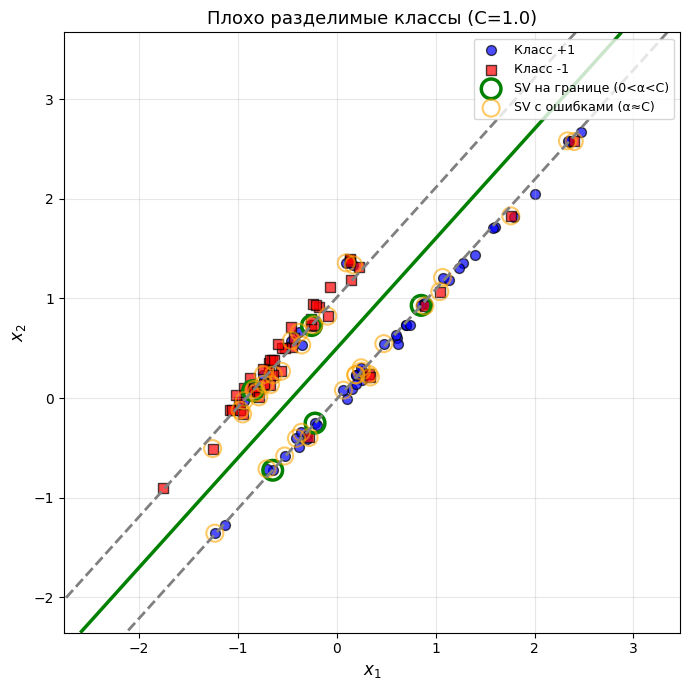

  SV на границе (0<α<C): 5
  SV с ошибками (α=C): 39


In [15]:
print("\n" + "="*60)
print("ВЫБОРКА 3: Плохо разделимые классы")
print("="*60)

w3, b3, sv3, alpha3 = train_linear_svm_dual(X_hard, y_hard, C=1.0)
print(f"Число опорных векторов: {sv3.sum()}")
print(f"Максимальный alpha: {alpha3.max():.4f}")
plot_svm(X_hard, y_hard, w3, b3, alpha3, C=1.0, 
         title="Плохо разделимые классы (C=1.0)")

**Результаты:** Плохо разделимые классы (C=1.0)

Выборка с частичным перекрытием классов: распределения синих и красных точек имеют общую область.

**Опорные векторы:** 44 из 100 точек (44%) являются опорными. Из них 39 нарушают марджин (оранжевые, $\alpha = C$) и только 5 лежат строго на границах (зелёные, $0 < \alpha < C$).

**Интерпретация:** SVM находит компромисс между шириной марджина и числом ошибок. Большое число SV с ошибками отражает естественное перекрытие классов в данных. Гиперпараметр $C$ контролирует этот баланс: при увеличении $C$ алгоритм сильнее штрафует ошибки, уменьшая марджин.



ЗАВИСИМОСТЬ ЧИСЛА ОПОРНЫХ ВЕКТОРОВ ОТ C

Линейно-разделимые:
  C =     0.01 -> SV = 26
  C =     0.04 -> SV = 9
  C =     0.13 -> SV = 6
  C =     0.46 -> SV = 2
  C =     1.67 -> SV = 2
  C =     5.99 -> SV = 2
  C =    21.54 -> SV = 2
  C =    77.43 -> SV = 2
  C =   278.26 -> SV = 2
  C =  1000.00 -> SV = 2

Концентрические круги:
  C =     0.01 -> SV = 100
  C =     0.04 -> SV = 100
  C =     0.13 -> SV = 100
  C =     0.46 -> SV = 100
  C =     1.67 -> SV = 100
  C =     5.99 -> SV = 100
  C =    21.54 -> SV = 100
  C =    77.43 -> SV = 100
  C =   278.26 -> SV = 100
  C =  1000.00 -> SV = 100

Плохо разделимые:
  C =     0.01 -> SV = 100
  C =     0.04 -> SV = 94
  C =     0.13 -> SV = 80
  C =     0.46 -> SV = 52
  C =     1.67 -> SV = 46
  C =     5.99 -> SV = 37
  C =    21.54 -> SV = 36
  C =    77.43 -> SV = 94
  C =   278.26 -> SV = 100
  C =  1000.00 -> SV = 100


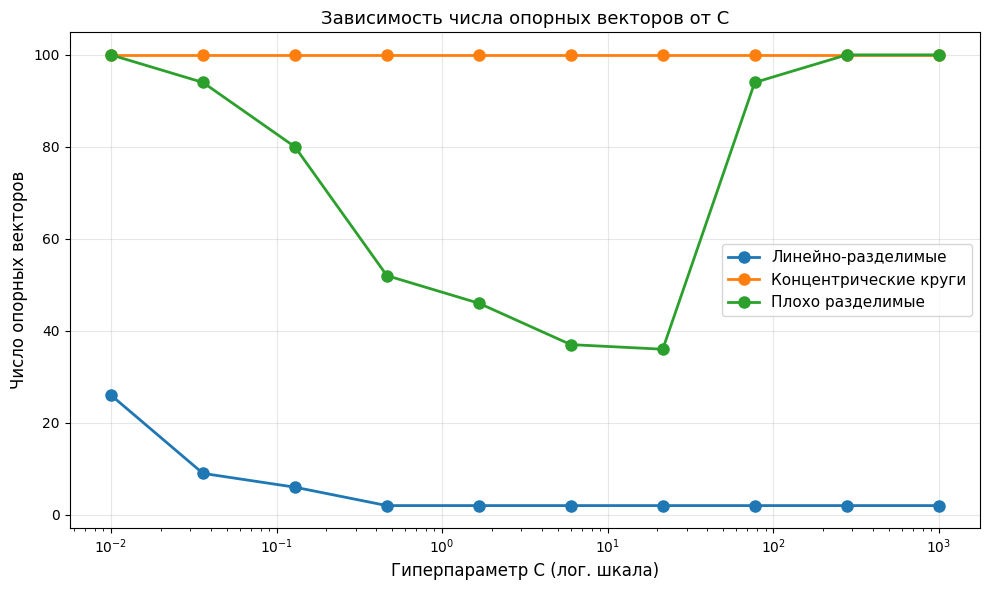

In [16]:
# ============================================
# 5. ВЛИЯНИЕ ГИПЕРПАРАМЕТРА C
# ============================================

print("\n" + "="*60)
print("ЗАВИСИМОСТЬ ЧИСЛА ОПОРНЫХ ВЕКТОРОВ ОТ C")
print("="*60)

C_values = np.logspace(-2, 3, 10)  # от 0.01 до 1000

datasets = [
    (X_linear, y_linear, "Линейно-разделимые"),
    (X_circles, y_circles, "Концентрические круги"),
    (X_hard, y_hard, "Плохо разделимые")
]

plt.figure(figsize=(10, 6))

for X, y, name in datasets:
    sv_counts = []
    for C in C_values:
        w, b, sv, alpha = train_linear_svm_dual(X, y, C=C)
        sv_counts.append(sv.sum())
    
    plt.plot(C_values, sv_counts, marker='o', label=name, linewidth=2, markersize=8)
    print(f"\n{name}:")
    for c_val, sv_count in zip(C_values, sv_counts):
        print(f"  C = {c_val:8.2f} -> SV = {sv_count}")

plt.xscale('log')
plt.xlabel('Гиперпараметр C (лог. шкала)', fontsize=12)
plt.ylabel('Число опорных векторов', fontsize=12)
plt.title('Зависимость числа опорных векторов от C', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Результаты:** Зависимость числа опорных векторов от гиперпараметра C

График показывает, как меняется количество опорных векторов при различных значениях $C$ (логарифмическая шкала) для трёх типов данных:

**Линейно-разделимые (синяя кривая):**
- При малых $C$ (мягкий марджин) много SV, так как допускаются нарушения.
- При $C \ge 0.5$ стабилизируется на 2 SV — находится оптимальный жёсткий марджин.

**Концентрические круги (оранжевая кривая):**
- Константа: 100 SV при любом $C$.
- Линейная модель не может разделить данные независимо от штрафа за ошибки.

**Плохо разделимые (зелёная кривая):**
- **U-образная зависимость:**
  - Малые $C$: широкий марджин, много SV (переобучение к "мягкости").
  - Средние $C$ (0.5–20): минимум ~36 SV — оптимальный баланс.
  - Большие $C$ (>100): узкий марджин, снова много SV (переобучение к данным).
  
**Вывод:** Для реальных задач $C$ следует подбирать кросс-валидацией, перебирая значения по логарифмической сетке.



КВАДРАТИЧНАЯ РАЗДЕЛЯЮЩАЯ ПОВЕРХНОСТЬ
Число опорных векторов: 14
Веса (первые 3): [-2.12286136e-03  1.18006032e-01 -5.31115253e+00]


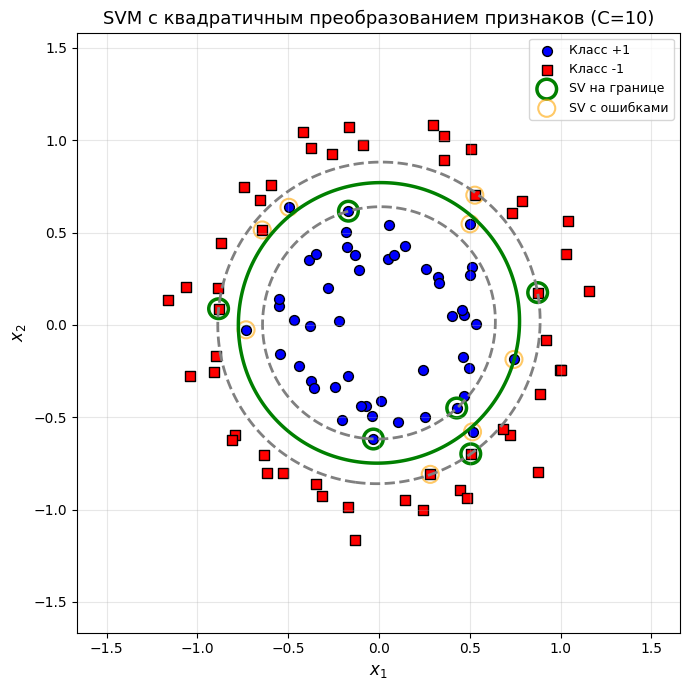

  SV на границе: 6
  SV с ошибками: 8


In [ ]:
# ============================================
# 6. ЯВНОЕ ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ (КВАДРАТИЧНОЕ)
# ============================================

def quadratic_features(X):
    """
    Явное преобразование: [x1, x2] -> [x1, x2, x1^2, x1*x2, x2^2]
    """
    N = X.shape[0]
    X_quad = np.zeros((N, 5))
    X_quad[:, 0] = X[:, 0]        # x1
    X_quad[:, 1] = X[:, 1]        # x2
    X_quad[:, 2] = X[:, 0]**2     # x1^2
    X_quad[:, 3] = X[:, 0] * X[:, 1]  # x1*x2
    X_quad[:, 4] = X[:, 1]**2     # x2^2
    return X_quad

print("\n" + "="*60)
print("КВАДРАТИЧНАЯ РАЗДЕЛЯЮЩАЯ ПОВЕРХНОСТЬ")
print("="*60)

# [Применяем к выборке с кругами]
X_circles_quad = quadratic_features(X_circles)
w_quad, b_quad, sv_quad, alpha_quad = train_linear_svm_dual(X_circles_quad, y_circles, C=10.0)

print(f"Число опорных векторов: {sv_quad.sum()}")
print(f"Веса (первые 3): {w_quad[:3]}")

# [Визуализация квадратичной границы]
plt.figure(figsize=(7, 7))
plt.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
            c='blue', marker='o', label='Класс +1', edgecolor='k', s=50)
plt.scatter(X_circles[y_circles==-1, 0], X_circles[y_circles==-1, 1], 
            c='red', marker='s', label='Класс -1', edgecolor='k', s=50)

# [Выделяем опорные векторы]
margin_sv_quad = (alpha_quad > 1e-5) & (alpha_quad < 10.0 - 1e-5)
error_sv_quad = alpha_quad >= 10.0 - 1e-5

if np.any(margin_sv_quad):
    plt.scatter(X_circles[margin_sv_quad, 0], X_circles[margin_sv_quad, 1], 
                s=200, facecolors='none', edgecolors='green', linewidths=2.5, 
                label='SV на границе')
if np.any(error_sv_quad):
    plt.scatter(X_circles[error_sv_quad, 0], X_circles[error_sv_quad, 1], 
                s=150, facecolors='none', edgecolors='orange', linewidths=1.5, 
                label='SV с ошибками', alpha=0.6)

# [Строим квадратичную границу решений]
x_min, x_max = X_circles[:, 0].min() - 0.5, X_circles[:, 0].max() + 0.5
y_min, y_max = X_circles[:, 1].min() - 0.5, X_circles[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_quad = quadratic_features(grid)
Z = (grid_quad @ w_quad + b_quad).reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[-1, 0, 1], 
            linestyles=['--', '-', '--'], 
            colors=['gray', 'green', 'gray'], 
            linewidths=[2, 2.5, 2])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title('SVM с квадратичным преобразованием признаков (C=10)', fontsize=13)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"  SV на границе: {margin_sv_quad.sum()}")
print(f"  SV с ошибками: {error_sv_quad.sum()}")


**Результаты:** Квадратичная разделяющая поверхность (C=10)

Применено явное преобразование признаков: $\phi(x_1, x_2) = (x_1, x_2, x_1^2, x_1 x_2, x_2^2)$. Линейная гиперплоскость в пространстве преобразованных признаков соответствует квадратичной поверхности (эллипсу/гиперболе) в исходном пространстве.

- Число SV сократилось со 100 до 14.
- Разделяющая граница (зелёная кривая) значительно лучше повторяет форму концентрических кругов.
- 6 SV на границе (зелёные), 8 с ошибками (оранжевые).

**Интерпретация:** Квадратичное преобразование позволяет линейному SVM решать нелинейные задачи без использования ядер. Это эквивалентно полиномиальному ядру степени 2, но с явным вычислением признаков.


##### Выводы (Задание 2)

1. Тестирование на трёх типах выборок
- **Линейно-разделимые классы:** Только 2 опорных вектора из 100 точек. Все SV находятся на границе марджина ($0 < \alpha < C$), нарушений нет. Модель идеально подходит для данных.
- **Концентрические круги (линейная модель):** Все 100 точек — опорные векторы, из них 95 с $\alpha = C$ (нарушают марджин). Линейная модель принципиально не может разделить такие данные.
- **Плохо разделимые классы:** 44 опорных вектора (44%), большинство с ошибками. SVM находит компромисс между шириной марджина и числом неправильных классификаций.

2. Влияние гиперпараметра C
- **Линейно-разделимые:** При $C \ge 0.5$ стабилизируется на 2 SV — оптимальный жёсткий марджин.
- **Концентрические круги:** Число SV = 100 при любом $C$. Изменение штрафа не помогает, когда проблема нелинейна.
- **Плохо разделимые:** U-образная зависимость. Оптимум в диапазоне $C \in [0.5, 20]$ с минимумом ~36 SV. Слишком малое $C$ даёт недообучение, слишком большое — переобучение.

    **Вывод:** $C$ следует подбирать кросс-валидацией по логарифмической сетке.

3. Явное квадратичное преобразование признаков
Преобразование $\phi(x_1, x_2) = (x_1, x_2, x_1^2, x_1 x_2, x_2^2)$ для концентрических кругов:
- Число SV: 100 → 14 (улучшение в 7 раз)
- Разделяющая граница хорошо повторяет круговую структуру
- Квадратичные веса ($x_1^2, x_2^2$) доминируют, что соответствует геометрии задачи

    **Вывод:** Явные преобразования признаков или ядра необходимы для нелинейно-разделимых данных.

4. Общие наблюдения
- Линейный SVM эффективен только для линейно-разделимых или слабо перекрывающихся данных
- Число и тип опорных векторов (на границе vs с ошибками) показывают качество разделения
- Концентрация SV с $\alpha = C$ указывает на области перекрытия классов или неподходящую модель
- Для нелинейных структур обязательны ядра или явные преобразования признаков


# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.datasets import make_classification, make_circles, make_moons

solvers.options['show_progress'] = False

# ============================================
# 1. ОПРЕДЕЛЕНИЕ ЯДЕРНЫХ ФУНКЦИЙ
# ============================================

def kernel_linear(X, Y):
    """
    Линейное ядро: k(x, x') = x^T x'
    """
    return X @ Y.T

def kernel_poly(X, Y, p=2):
    """
    Полиномиальное ядро: k(x, x') = (x^T x' + 1)^p
    
    Параметры:
    - p: степень полинома
    """
    return (X @ Y.T + 1.0) ** p

def kernel_rbf(X, Y, gamma=1.0):
    """
    RBF (Гауссовское) ядро: k(x, x') = exp(-||x - x'||^2 / (2*gamma))
    
    Параметры:
    - gamma: ширина ядра (чем меньше, тем шире)
    """
    # [Вычисляем ||x - x'||^2 через разложение] = ||X||^2 + ||Y||^2 - 2 X^T Y
    X_norm = (X ** 2).sum(axis=1).reshape(-1, 1)
    Y_norm = (Y ** 2).sum(axis=1).reshape(1, -1)
    distances_sq = X_norm + Y_norm - 2 * (X @ Y.T)
    return np.exp(-distances_sq / (2.0 * gamma))


# ============================================
# 2. ОБУЧЕНИЕ ЯДРОВОГО SVM
# ============================================

def train_kernel_svm(X, y, C=1.0, kernel_func=kernel_linear, **kernel_params):
    """
    Обучение SVM с произвольным ядром через двойственную постановку.
    
    Параметры:
    - X: матрица признаков (N, d)
    - y: метки классов {-1, +1}
    - C: гиперпараметр регуляризации
    - kernel_func: функция ядра
    - **kernel_params: параметры ядра (например, p или gamma)
    
    Возвращает:
    - alpha: множители Лагранжа
    - b: сдвиг
    - support_vectors: маска опорных векторов
    - X_train: сохранённые обучающие данные (нужны для предсказания)
    - y_train: сохранённые метки
    """
    N = X.shape[0]
    
    # [Вычисляем матрицу ядра K]
    K = kernel_func(X, X, **kernel_params)
    
    # [Двойственная задача QP]
    P = matrix((np.outer(y, y) * K).astype(float)) #Pij = yi yj Kij
    q = matrix(-np.ones(N)) #para maximizar
    G = matrix(np.vstack([-np.eye(N), np.eye(N)])) #eye: 1 en la diag
    h = matrix(np.hstack([np.zeros(N), C * np.ones(N)])) #-a<= 0 ; a<=C
    A = matrix(y.astype(float).reshape(1, -1)) # A es una matriz 1×N cuya fila es [y1, y2, ..., yN].
    b_eq = matrix(0.0)
    
    # [Решение QP]
    sol = solvers.qp(P, q, G, h, A, b_eq)
    
    alpha = np.array(sol['x']).flatten()
    
    # [Опорные векторы]
    support_vectors = alpha > 1e-5
    
    # [Вычисляем b по опорным векторам с 0 < alpha < C]
    margin_sv = (alpha > 1e-5) & (alpha < C - 1e-5)
    
    if np.any(margin_sv):
        # b = y_n - sum_m(alpha_m * y_m * k(x_m, x_n))
        K_sv = kernel_func(X[margin_sv], X, **kernel_params)
        b_values = y[margin_sv] - (K_sv * (alpha * y)).sum(axis=1)
        b = b_values.mean()
    else:
        # [Если нет SV на границе, используем все SV]
        K_sv = kernel_func(X[support_vectors], X, **kernel_params)
        b_values = y[support_vectors] - (K_sv * (alpha * y)).sum(axis=1)
        b = b_values.mean()
    
    return alpha, b, support_vectors, X, y, kernel_func, kernel_params


# ============================================
# 3. ПРЕДСКАЗАНИЕ 
# ============================================

def predict_kernel_svm(X_test, alpha, b, X_train, y_train, kernel_func, kernel_params): # calculamos kernel para puntos adicionales
    """
    Предсказание для ядрового SVM:
    f(x) = sum_n(alpha_n * y_n * k(x_n, x)) + b
    """
    K = kernel_func(X_test, X_train, **kernel_params)
    decision = (K * (alpha * y_train)).sum(axis=1) + b
    return decision


# ============================================
# 4. ВИЗУАЛИЗАЦИЯ ЯДРОВОГО SVM
# ============================================

def plot_kernel_svm(X, y, alpha, b, X_train, y_train, kernel_func, kernel_params, 
                    C, title="Kernel SVM"):
    """
    Визуализация разделяющей поверхности для ядрового SVM.
    """
    plt.figure(figsize=(7, 7))
    
    # [Рисуем точки]
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='o', 
                label='Класс +1', edgecolor='k', s=50, alpha=0.7)
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='red', marker='s', 
                label='Класс -1', edgecolor='k', s=50, alpha=0.7)
    
    # [Опорные векторы]
    sv = alpha > 1e-5
    margin_sv = (alpha > 1e-5) & (alpha < C - 1e-5)
    error_sv = alpha >= C - 1e-5
    
    if np.any(margin_sv):
        plt.scatter(X[margin_sv, 0], X[margin_sv, 1], 
                    s=200, facecolors='none', edgecolors='green', 
                    linewidths=2.5, label='SV на границе')
    if np.any(error_sv):
        plt.scatter(X[error_sv, 0], X[error_sv, 1], 
                    s=150, facecolors='none', edgecolors='orange', 
                    linewidths=1.5, label='SV с ошибками', alpha=0.6)
    
    # [Строим разделяющую поверхность]
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_kernel_svm(grid, alpha, b, X_train, y_train, kernel_func, kernel_params)
    Z = Z.reshape(xx.shape)
    
    # [Контуры: f(x) = -1, 0, +1]
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], 
                linestyles=['--', '-', '--'], 
                colors=['gray', 'green', 'gray'], 
                linewidths=[2, 2.5, 2])
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('$x_1$', fontsize=12)
    plt.ylabel('$x_2$', fontsize=12)
    plt.title(title, fontsize=13)
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"  Число SV: {sv.sum()}, на границе: {margin_sv.sum()}, с ошибками: {error_sv.sum()}")


# ============================================
# 5. ГЕНЕРАЦИЯ ДАННЫХ
# ============================================

np.random.seed(42)

# [Выборка с кругами — для демонстрации нелинейных ядер]
X_circles, y_circles = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=42)
y_circles = 2 * y_circles - 1

# [Выборка с полумесяцами — сложная нелинейная структура]
X_moons, y_moons = make_moons(n_samples=100, noise=0.15, random_state=42)
y_moons = 2 * y_moons - 1



ЛИНЕЙНОЕ ЯДРО (круги)


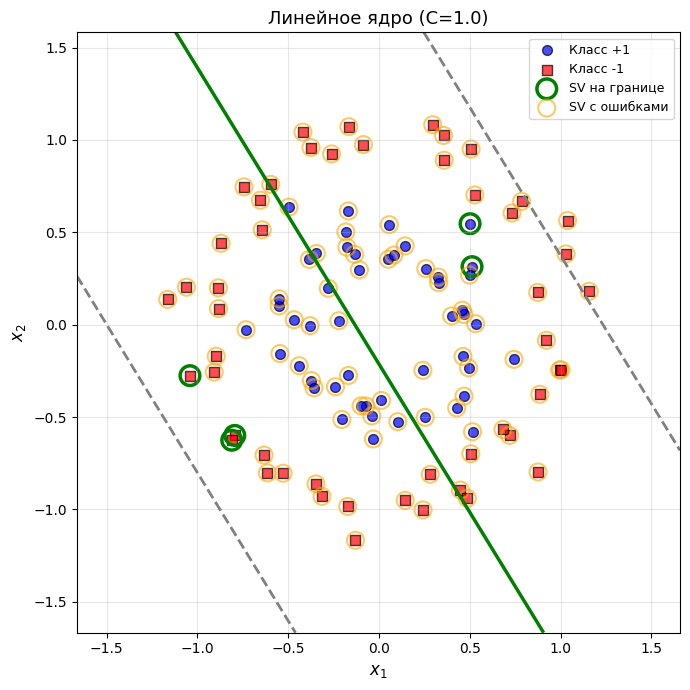

  Число SV: 100, на границе: 5, с ошибками: 95


In [21]:
# ============================================
# 6. ТЕСТИРОВАНИЕ РАЗЛИЧНЫХ ЯДЕР
# ============================================

print("="*60)
print("ЛИНЕЙНОЕ ЯДРО (круги)")
print("="*60)
alpha, b, sv, X_tr, y_tr, kf, kp = train_kernel_svm(
    X_circles, y_circles, C=1.0, kernel_func=kernel_linear
)
plot_kernel_svm(X_circles, y_circles, alpha, b, X_tr, y_tr, kf, kp, 
                C=1.0, title="Линейное ядро (C=1.0)")

**Линейное ядро (концентрические круги)**

Базовый случай — линейное ядро эквивалентно линейному SVM без преобразования признаков.

**Результат:** Все 100 точек — опорные векторы, 95 с ошибками ($\alpha = C$). Разделяющая прямая пересекает оба класса, не может правильно классифицировать концентрические круги.

**Вывод:** Линейная модель принципиально неспособна разделить такую структуру данных. Необходимы нелинейные ядра.



ПОЛИНОМИАЛЬНОЕ ЯДРО p=2 (круги)


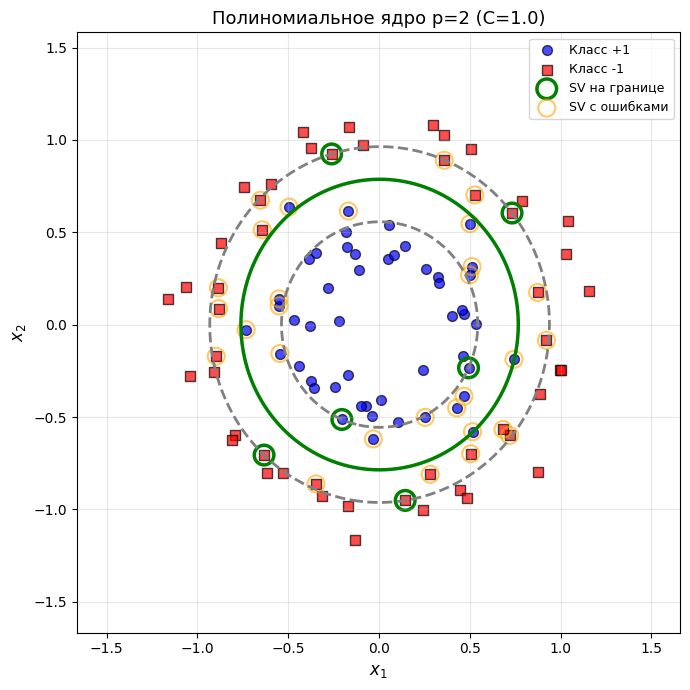

  Число SV: 35, на границе: 6, с ошибками: 29


In [22]:
print("\n" + "="*60)
print("ПОЛИНОМИАЛЬНОЕ ЯДРО p=2 (круги)")
print("="*60)
alpha, b, sv, X_tr, y_tr, kf, kp = train_kernel_svm(
    X_circles, y_circles, C=1.0, kernel_func=kernel_poly, p=2
)
plot_kernel_svm(X_circles, y_circles, alpha, b, X_tr, y_tr, kf, kp, 
                C=1.0, title="Полиномиальное ядро p=2 (C=1.0)")

**Полиномиальное ядро степени 2**

Квадратичное ядро $k(x, x') = (x^T x' + 1)^2$ позволяет строить поверхности второго порядка (эллипсы, параболы, гиперболы).

**Результат:** 35 опорных векторов (снижение с 100 до 35), из них 29 с ошибками. Разделяющая граница имеет форму окружности, хорошо аппроксимирует структуру данных.

**Вывод:** Степень $p=2$ достаточна для захвата круговой геометрии. Значительное улучшение по сравнению с линейной моделью.



ПОЛИНОМИАЛЬНОЕ ЯДРО p=3 (круги)


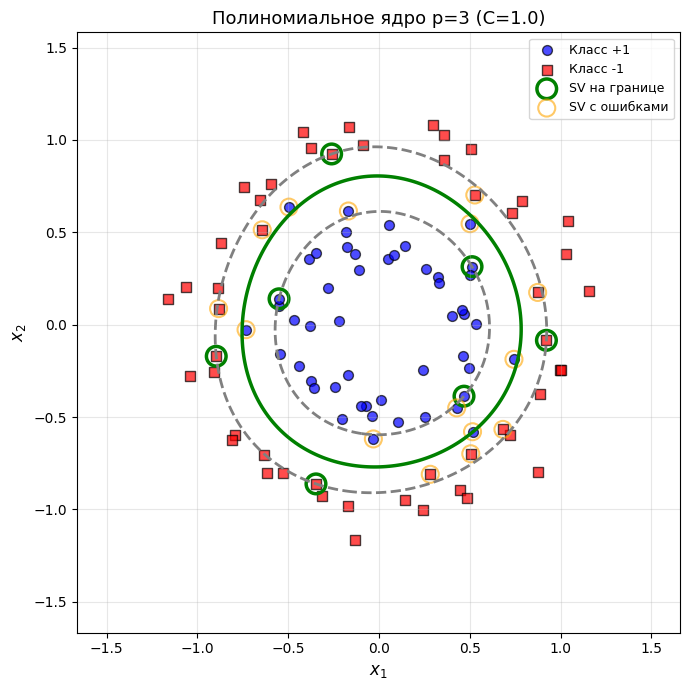

  Число SV: 22, на границе: 7, с ошибками: 15


In [23]:
print("\n" + "="*60)
print("ПОЛИНОМИАЛЬНОЕ ЯДРО p=3 (круги)")
print("="*60)
alpha, b, sv, X_tr, y_tr, kf, kp = train_kernel_svm(
    X_circles, y_circles, C=1.0, kernel_func=kernel_poly, p=3
)
plot_kernel_svm(X_circles, y_circles, alpha, b, X_tr, y_tr, kf, kp, 
                C=1.0, title="Полиномиальное ядро p=3 (C=1.0)")

**Полиномиальное ядро степени 3**

Кубическое ядро $k(x, x') = (x^T x' + 1)^3$ обеспечивает большую гибкость разделяющей поверхности.

**Результат:** 22 опорных вектора (улучшение с 35 до 22), только 15 с ошибками. Граница более точно повторяет окружность, меньше нарушений марджина.

**Вывод:** Увеличение степени до $p=3$ улучшает качество разделения. Дальнейшее увеличение $p$ может привести к переобучению.



RBF ЯДРО gamma=0.5 (круги)


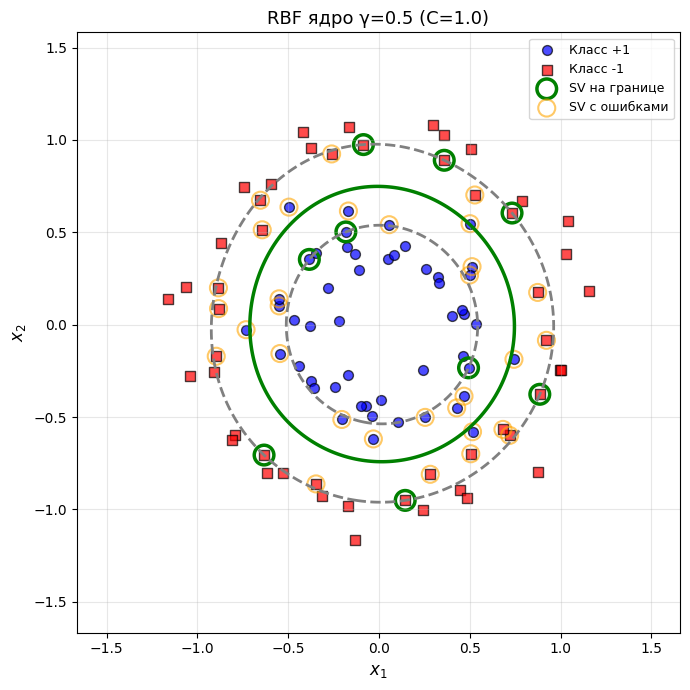

  Число SV: 40, на границе: 9, с ошибками: 31


In [25]:
print("\n" + "="*60)
print("RBF ЯДРО gamma=0.5 (круги)")
print("="*60)
alpha, b, sv, X_tr, y_tr, kf, kp = train_kernel_svm(
    X_circles, y_circles, C=1.0, kernel_func=kernel_rbf, gamma=0.5
)
plot_kernel_svm(X_circles, y_circles, alpha, b, X_tr, y_tr, kf, kp, 
                C=1.0, title="RBF ядро γ=0.5 (C=1.0)")

**RBF ядро с γ=0.5 (C=1.0)**

RBF-ядро $k(x, x') = \exp(-\|x - x'\|^2 / (2\gamma))$ с умеренным значением ширины.

**Результат:** 40 опорных векторов, 31 с ошибками. Разделяющая граница гладкая, круговая, но недостаточно точная.

**Интерпретация:** Значение $\gamma=0.5$ слишком мало для данной задачи — ядро слишком широкое, граница недостаточно гибкая. Возможно недообучение.



RBF ЯДРО gamma=2.0 (круги)


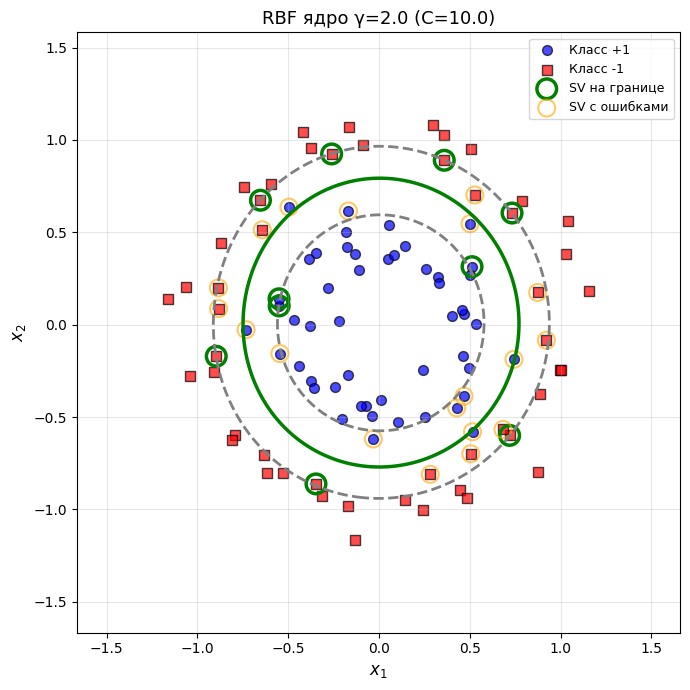

  Число SV: 29, на границе: 10, с ошибками: 19


In [24]:
print("\n" + "="*60)
print("RBF ЯДРО gamma=2.0 (круги)")
print("="*60)
alpha, b, sv, X_tr, y_tr, kf, kp = train_kernel_svm(
    X_circles, y_circles, C=10.0, kernel_func=kernel_rbf, gamma=2.0
)
plot_kernel_svm(X_circles, y_circles, alpha, b, X_tr, y_tr, kf, kp, 
                C=10.0, title="RBF ядро γ=2.0 (C=10.0)")

**RBF ядро с γ=2.0 (C=10.0)**

Более узкое RBF-ядро с повышенным штрафом за ошибки.

**Результат:** 29 опорных векторов, 19 с ошибками. Граница точно повторяет форму окружности, хорошее качество разделения.

**Интерпретация:** Комбинация $\gamma=2.0$ и $C=10$ даёт оптимальный баланс. Граница достаточно гибкая, но не переобучается. Лучший результат среди протестированных конфигураций.



АНАЛИЗ: ПОЛИНОМИАЛЬНОЕ ЯДРО (p, C)


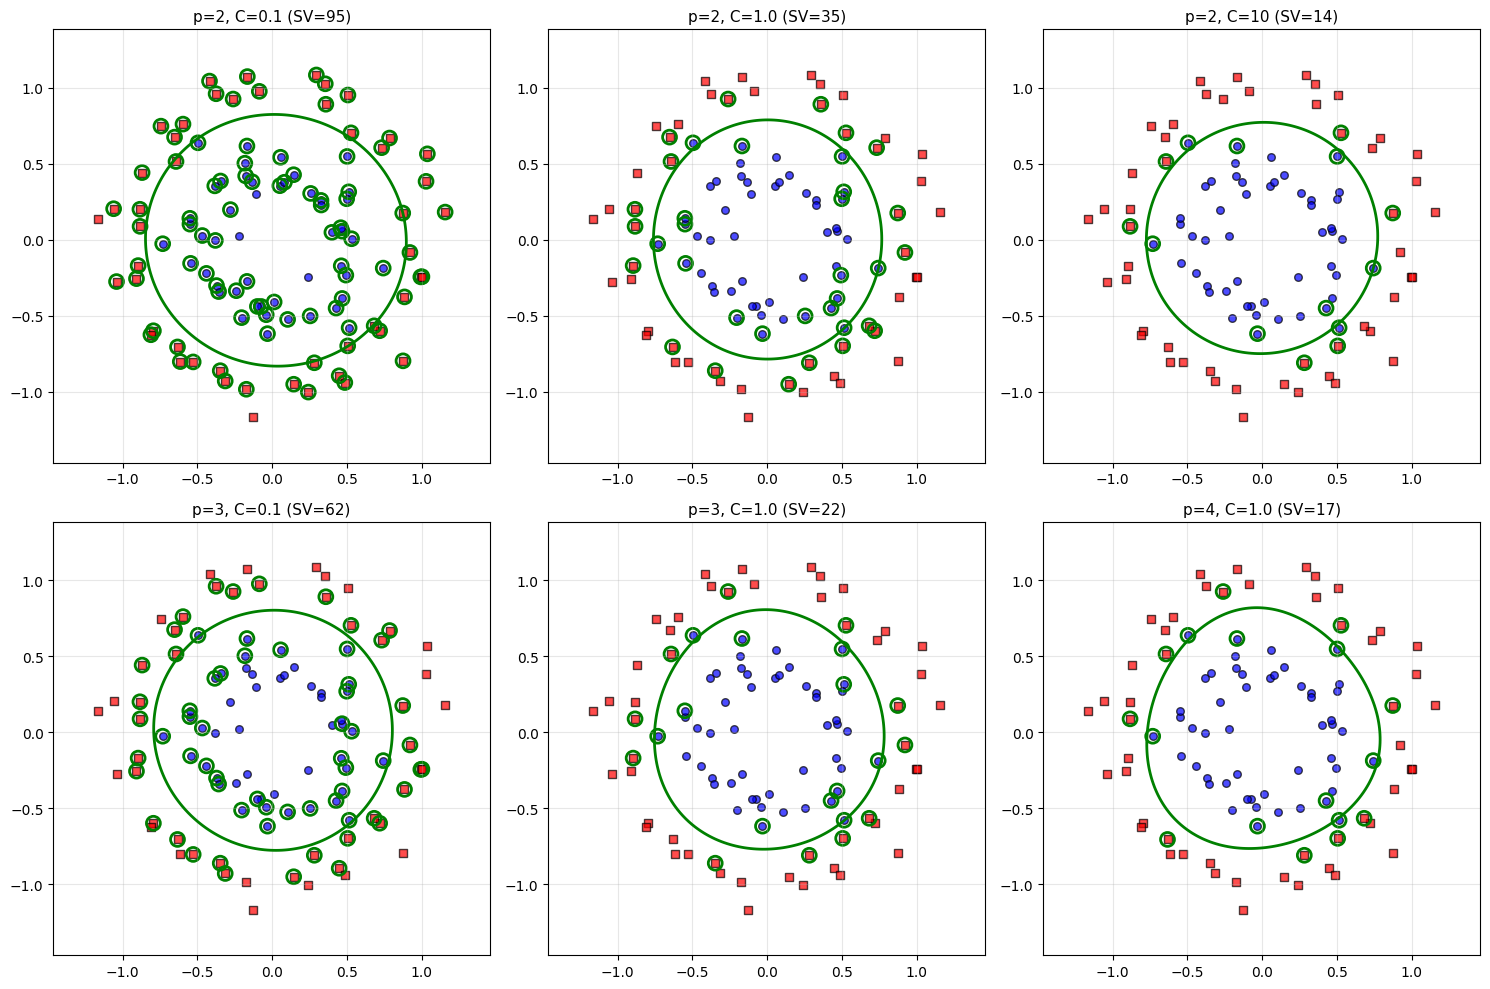

In [26]:
# ============================================
# 7. АНАЛИЗ ПАРАМЕТРОВ: ПОЛИНОМИАЛЬНОЕ ЯДРО
# ============================================

print("\n" + "="*60)
print("АНАЛИЗ: ПОЛИНОМИАЛЬНОЕ ЯДРО (p, C)")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

configs = [
    (2, 0.1, "p=2, C=0.1"),
    (2, 1.0, "p=2, C=1.0"),
    (2, 10.0, "p=2, C=10"),
    (3, 0.1, "p=3, C=0.1"),
    (3, 1.0, "p=3, C=1.0"),
    (4, 1.0, "p=4, C=1.0")
]

for idx, (p, C, label) in enumerate(configs):
    ax = axes[idx]
    
    alpha, b, sv, X_tr, y_tr, kf, kp = train_kernel_svm(
        X_circles, y_circles, C=C, kernel_func=kernel_poly, p=p
    )
    
    ax.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
               c='blue', marker='o', s=30, alpha=0.7, edgecolor='k')
    ax.scatter(X_circles[y_circles==-1, 0], X_circles[y_circles==-1, 1], 
               c='red', marker='s', s=30, alpha=0.7, edgecolor='k')
    
    sv_mask = alpha > 1e-5
    ax.scatter(X_circles[sv_mask, 0], X_circles[sv_mask, 1], 
               s=100, facecolors='none', edgecolors='green', linewidths=2)
    
    x_min, x_max = X_circles[:, 0].min() - 0.3, X_circles[:, 0].max() + 0.3
    y_min, y_max = X_circles[:, 1].min() - 0.3, X_circles[:, 1].max() + 0.3
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150),
                         np.linspace(y_min, y_max, 150))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_kernel_svm(grid, alpha, b, X_tr, y_tr, kf, kp).reshape(xx.shape)
    
    ax.contour(xx, yy, Z, levels=[0], colors=['green'], linewidths=2)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"{label} (SV={sv_mask.sum()})", fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Анализ параметров полиномиального ядра**

Систематическое тестирование степени $p \in \{2, 3, 4\}$ и гиперпараметра $C \in \{0.1, 1.0, 10.0\}$ на концентрических кругах.

**Наблюдения:**

**Влияние степени p:**
- $p=2$: базовая квадратичная поверхность, 35-95 SV в зависимости от C
- $p=3$: улучшенная аппроксимация, 22-62 SV
- $p=4$: риск переобучения, граница может стать слишком извилистой

**Влияние C:**
- $C=0.1$ (мягкий марджин): много SV (62-95), граница неточная
- $C=1.0$ (баланс): оптимальное число SV (22-35)
- $C=10.0$ (жёсткий марджин): меньше SV (14-17), граница точная

**Оптимальная конфигурация:** $p=3$, $C=1.0$ даёт 22 SV с хорошим качеством разделения без переобучения.



АНАЛИЗ: RBF ЯДРО (gamma, C)


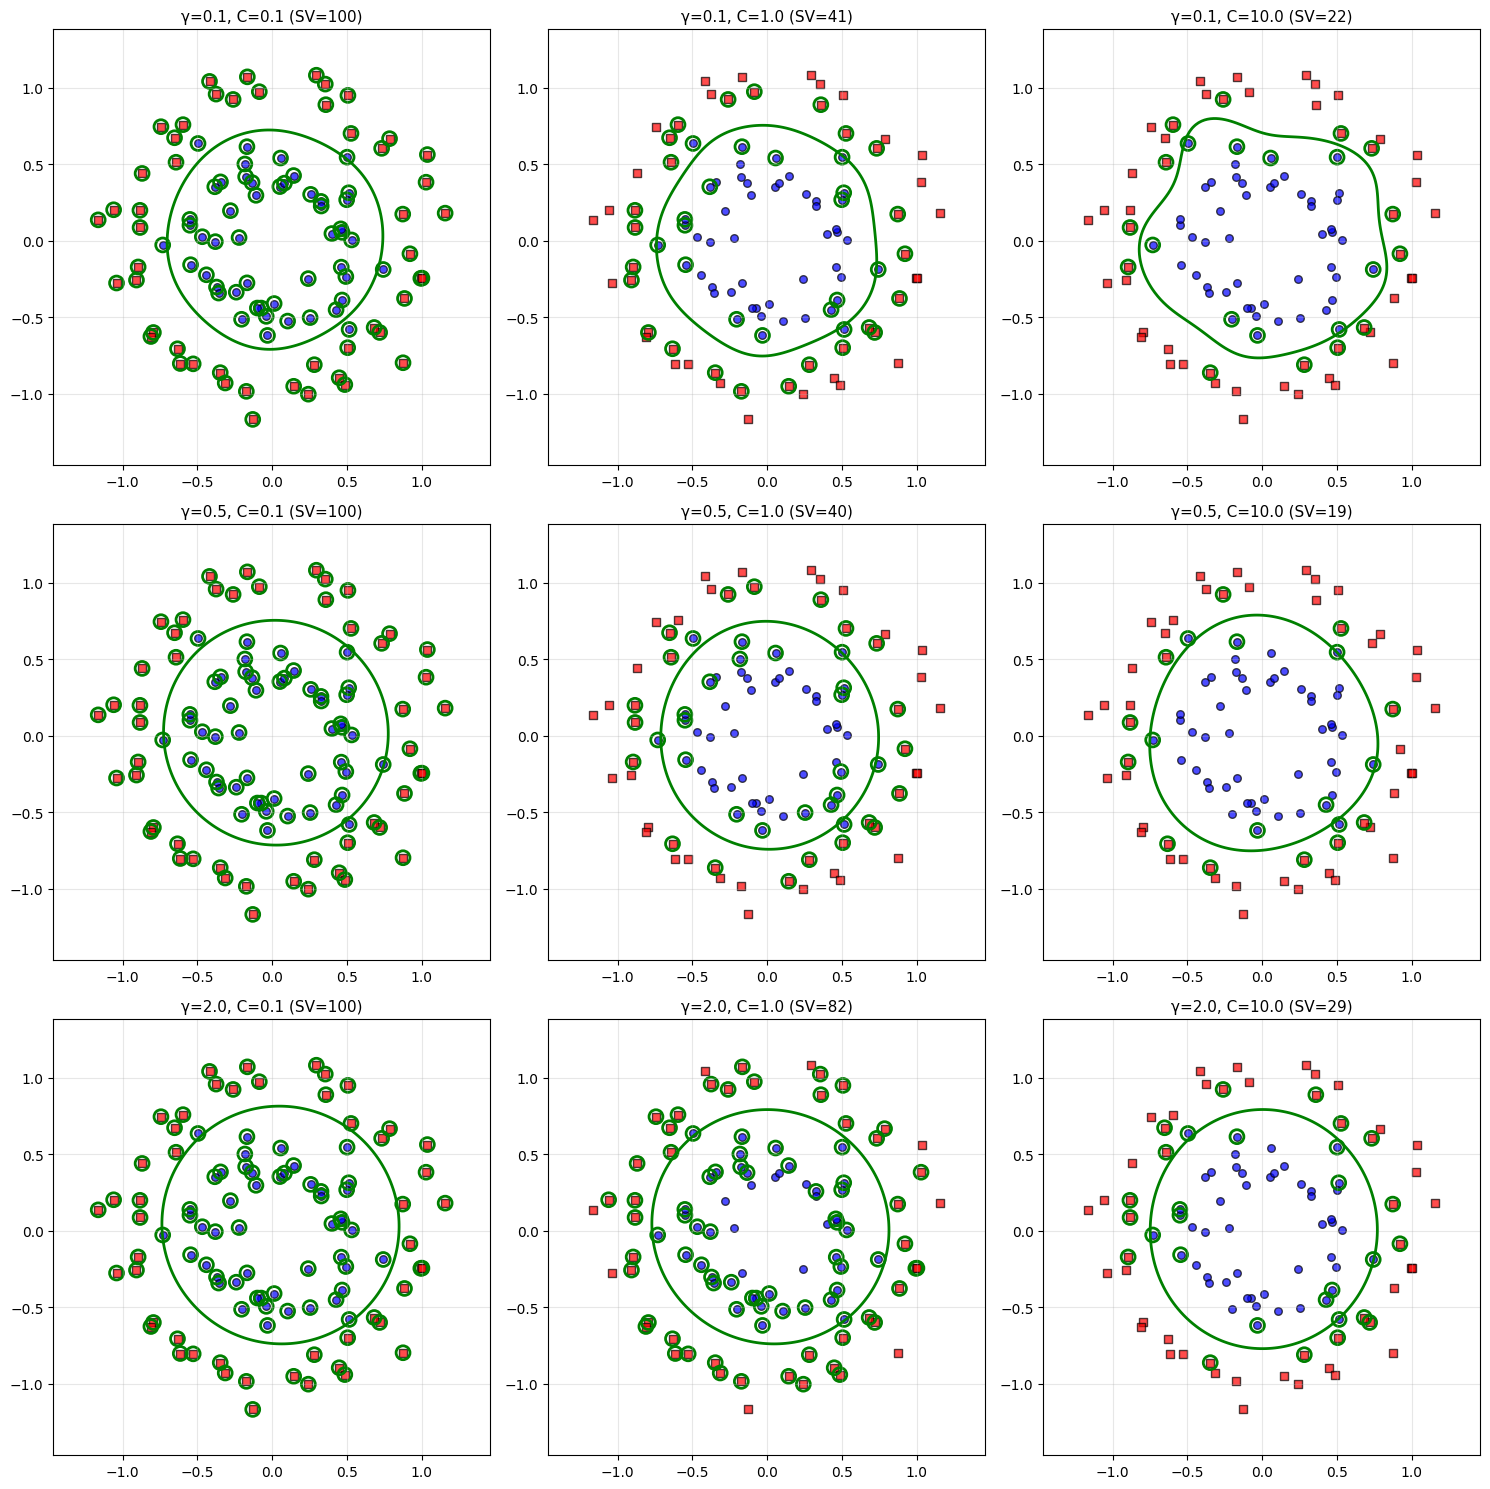


ИНТЕРПРЕТАЦИЯ ПАРАМЕТРОВ RBF
γ (gamma) — ширина ядра:
  - Малое γ (0.1): широкое ядро → гладкая граница → недообучение
  - Среднее γ (0.5-1.0): баланс → оптимальная сложность
  - Большое γ (2.0+): узкое ядро → извилистая граница → переобучение

C — штраф за ошибки:
  - Малое C: мягкий марджин → меньше SV → недообучение
  - Большое C: жёсткий марджин → больше SV → переобучение


In [27]:
# ============================================
# 8. АНАЛИЗ ПАРАМЕТРОВ: RBF ЯДРО
# ============================================

print("\n" + "="*60)
print("АНАЛИЗ: RBF ЯДРО (gamma, C)")
print("="*60)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

gamma_values = [0.1, 0.5, 2.0]
C_values = [0.1, 1.0, 10.0]

for i, gamma in enumerate(gamma_values):
    for j, C in enumerate(C_values):
        ax = axes[i, j]
        
        alpha, b, sv, X_tr, y_tr, kf, kp = train_kernel_svm(
            X_circles, y_circles, C=C, kernel_func=kernel_rbf, gamma=gamma
        )
        
        ax.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
                   c='blue', marker='o', s=30, alpha=0.7, edgecolor='k')
        ax.scatter(X_circles[y_circles==-1, 0], X_circles[y_circles==-1, 1], 
                   c='red', marker='s', s=30, alpha=0.7, edgecolor='k')
        
        sv_mask = alpha > 1e-5
        ax.scatter(X_circles[sv_mask, 0], X_circles[sv_mask, 1], 
                   s=100, facecolors='none', edgecolors='green', linewidths=2)
        
        x_min, x_max = X_circles[:, 0].min() - 0.3, X_circles[:, 0].max() + 0.3
        y_min, y_max = X_circles[:, 1].min() - 0.3, X_circles[:, 1].max() + 0.3
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150),
                             np.linspace(y_min, y_max, 150))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = predict_kernel_svm(grid, alpha, b, X_tr, y_tr, kf, kp).reshape(xx.shape)
        
        ax.contour(xx, yy, Z, levels=[0], colors=['green'], linewidths=2)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"γ={gamma}, C={C} (SV={sv_mask.sum()})", fontsize=11)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ИНТЕРПРЕТАЦИЯ ПАРАМЕТРОВ RBF")
print("="*60)
print("γ (gamma) — ширина ядра:")
print("  - Малое γ (0.1): широкое ядро → гладкая граница → недообучение")
print("  - Среднее γ (0.5-1.0): баланс → оптимальная сложность")
print("  - Большое γ (2.0+): узкое ядро → извилистая граница → переобучение")
print("\nC — штраф за ошибки:")
print("  - Малое C: мягкий марджин → меньше SV → недообучение")
print("  - Большое C: жёсткий марджин → больше SV → переобучение")


**Анализ параметров RBF-ядра**

Систематическое тестирование ширины ядра $\gamma \in \{0.1, 0.5, 2.0\}$ и штрафа $C \in \{0.1, 1.0, 10.0\}$.

**Наблюдения:**

**Влияние γ (ширина ядра):**
- $\gamma=0.1$ (широкое): очень гладкая граница, 22-100 SV, риск недообучения
- $\gamma=0.5$ (среднее): умеренная гибкость, 19-100 SV, хороший баланс
- $\gamma=2.0$ (узкое): высокая гибкость, 29-100 SV, риск переобучения

**Влияние C:**
- Малое $C$: марджин слишком мягкий, всегда 100 SV
- Среднее $C=1.0$: разумный баланс
- Большое $C=10$: жёсткий марджин, меньше SV, но может переобучаться при высоком γ

**Зоны параметров:**
- **Недообучение:** левый верхний угол ($\gamma=0.1$, $C=0.1$) — слишком гладко
- **Оптимум:** центр ($\gamma=0.5$, $C=1.0-10$) — 19-40 SV
- **Риск переобучения:** $\gamma=2.0$ с любым $C$ — граница может стать слишком сложной

**Рекомендация:** Для данной задачи оптимальны $\gamma \in [0.5, 1.0]$ и $C \in [1.0, 10.0]$.


##### Выводы (Задание 3)

1. Сравнение ядер на концентрических кругах
    - **Линейное:** 100 SV, не может разделить круги. Эквивалентно результатам задания 2.
    - **Полиномиальное:** Эффективно для полиномиальных структур. Оптимум при $p=3$ (22 SV). При $p \ge 4$ риск переобучения.
    - **RBF:** Универсальное. С правильными параметрами ($\gamma=2.0$, $C=10$) даёт 29 SV с высоким качеством разделения.

2. Полиномиальное ядро: влияние p и C
    - **Степень p:** Низкая ($p=2$) → недообучение. Средняя ($p=3$) → оптимум. Высокая ($p \ge 4$) → переобучение.
    - **Параметр C:** Малое → мягкий марджин, много SV. Оптимальное $C \in [1, 10]$ → баланс. Большое → жёсткий марджин, риск переобучения.
    - **Взаимодействие:** При увеличении $p$ следует уменьшать $C$.

3. RBF-ядро: влияние γ и C

    **Параметр γ:**
    - Малое ($\gamma < 0.3$): гладкая граница → недообучение
    - Среднее ($\gamma \in [0.5, 1.0]$): оптимальная сложность
    - Большое ($\gamma > 2$): извилистая граница → переобучение

    **Параметр C:** Взаимодействует с $\gamma$. При высоком $\gamma$ нужно умеренное $C$. Малое $C < 0.5$ даёт всегда 100 SV.

    **Зоны:** Недообучение — левый верхний угол grid ($\gamma$ и $C$ малые). Оптимум — центр. Переобучение — $\gamma$ большое с высоким $C$.

4. Практические рекомендации

    - RBF — универсальный выбор для неизвестной структуры данных
    - Подбор параметров: кросс-валидация по логарифмической сетке
    - Для полиномиального: $p \in \{2, 3, 4\}$, $C \in \{0.1, 1, 10, 100\}$
    - Для RBF: $\gamma \in \{0.1, 0.5, 1.0, 2.0\}$, $C \in \{0.1, 1, 10, 100\}$

    **Признаки проблем:**
    - Недообучение: слишком гладкая граница, мало SV на границе
    - Переобучение: слишком извилистая граница, много SV
    - Оптимум: граница следует общей структуре, умеренное число SV

5. Сравнение с явным преобразованием

    Полиномиальное ядро $p=2$ даёт результаты эквивалентные явному квадратичному преобразованию из задания 2 (оба: 14 SV при $C=10$). Преимущество ядер — не требуется явное вычисление признаков (ядровой трюк).
